# ViT Study
1. Image Patches : 

2. embedding patches 

3. scaled_dot_product_attention

4. Self-Attention : 

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

Prepare input image tensor</summary>

In [4]:
# Dummy Image Input
# image_tensor = torch.rand(1, 3, 32, 32)  # [batch, channel, H, W]

# Real Image Input
image_transforms = transforms.Compose([
            # transforms.Resize((224, 224)), # Resize image
            transforms.ToTensor(),           # image to a Torch tensor (C, H, W)
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])]) # imagenet mean & stds

cwd = os.getcwd()
img_path = cwd + '/cifar10-cat.png'  # 32x32
image = Image.open(img_path)
image_tensor = image_transforms(image)  # not img_path
image_tensor = image_tensor.unsqueeze(0) # 4D input: [batch, ch, H, W]


Extract Patches from the input image & Display

In [ ]:
# 하이퍼파라미터
PATCH_SIZE = 8 # num_pixels of each patch
d_model    = 128
d_k        = 64
#-----------------------------------------------------------------
# Step 1. image_tensor → extract_patches 
# 32×32 이미지를 8×8 패치로 자르면 → (32/8) × (32/8) = 16개 패치
batch_size  = image_tensor.shape[0]
num_patches = (32 // PATCH_SIZE) ** 2   # 16
patch_dim = 3 * PATCH_SIZE * PATCH_SIZE 

"""
# patch_dim : 한 patch 당 픽셀수 x 3(채널수) = dimension of each patch
patch_dim = 3 * PATCH_SIZE * PATCH_SIZE  # 192  (텍스트의 vocab과 대응)
# unfold로 패치 추출
x1 = image_tensor.unfold(2, PATCH_SIZE, PATCH_SIZE).unfold(3, PATCH_SIZE, PATCH_SIZE)
# shape: [1, 3, 4, 4, 8, 8]
x = x1.contiguous().view(batch_size, num_patches, patch_dim)
# shape: [1, 16, 192] ← (batch, seq_len, patch_dim) = [batch, num_patches, patch_dim] 
print("패치 shape:", x.shape)  # [1, 16, 192] 

"""
unfold = torch.nn.Unfold(kernel_size=PATCH_SIZE, stride=PATCH_SIZE)
x1 = unfold(image_tensor)   # [1, 192, 16]
x = x1.transpose(1,2)       # [1, 16, 192] ← (batch, seq_len, patch_dim) = [batch, num_patches, patch_dim] 

"""
--------------------------------------------------------------------------------
원본 image:  [■■■■■■■■■■■■] ← 메모리에 연속적으로 저장
Tensor.unfold 후:   실제 메모리는 그대로인데
                    다른 방식으로 "참조"만 바꾼 상태 → 비연속적(non-contiguous)

# 확인 방법
print(image.is_contiguous())          # True
print(image.unfold(2,8,8).unfold(3,8,8).is_contiguous())  # False ← view() 불가!
--------------------------------------------------------------------------------

# A. nn.Unfold 사용시 후처리
unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size) 
                       [1, 3, 32, 32] → [1, 192, 16]
#                                            ↑    ↑
#                                      채널×패치픽셀  패치수
x = nn.unfold(image)            # [1, 192, 16]
x = x.transpose(1, 2)           # [1, 16, 192]  ← 이것만으로 완성

# B. Tensor.unfold 사용시 후처리
x = image.unfold(2,8,8).unfold(3,8,8)  # [1, 3, 4, 4, 8, 8]
x = x.contiguous().view(1, 16, 192)    # 더 복잡한 재구성 필요

# reshape = contiguous() + view()를 합친 것
x = x.reshape(batch_size, num_patches, patch_dim)  # 이 한 줄로 대체 가능

"""

len(img_seq) 16


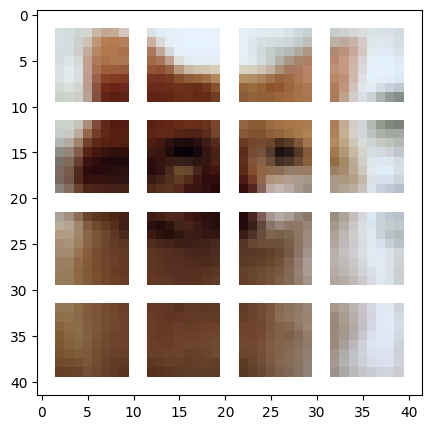

In [6]:
def extract_patches(images_tensor, patch_size=PATCH_SIZE):
    # mutli-images as a batch : images_tensor =[batch, ch, H, W]
    batch_size, c, h, w = images_tensor.size()
    """
    torch.nn.Unfold meaning :
    To extracts sliding local blocks (patches) from a batched input tensor
    """
    unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    unfolded = unfold(images_tensor)
    # Reshape the unfolded tensor: [batch_size, num_patches, patch_dim]
    img_patches = unfolded.transpose(1, 2).reshape(batch_size, -1, c * patch_size * patch_size)
    return img_patches

#patches.shape : [1, 16, 192] (1 img, 4x4 patches, 3x8x8)
patches = extract_patches(image_tensor, patch_size=PATCH_SIZE)
#patches_square.shape: [1, 16, 3, 8, 8] = [1 img, 4x4 patch, num_ch, patch_size, patch_size] 
# patch_size = num_pixels of one-side 
square_patches = patches.reshape(image_tensor.shape[0], -1, 3, PATCH_SIZE, PATCH_SIZE)

# make grid for patch visualization
grid_size = image_tensor.shape[2] // PATCH_SIZE
print("len(img_seq) %d" % (grid_size**2))  # num_patches

#%%
# Visualize the patches as a grid
plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(square_patches[0], grid_size, normalize=True, pad_value=1.0) #pad_value : color
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))


<details>
<summary>Patch Embedding</summary>

```
실제 트랜스포머에서 Q, K, V 생성 방식
patch_embedding : associates Patches with Weights in 
Linear Projection/Embedding (텍스트의 nn.Embedding 역할) 
```
</details>

In [8]:
patch_embedding = nn.Linear(patch_dim, d_model)  # in_feat=192 → out_feat = 128
x = patch_embedding(x)
# shape: [1, 16, 128] ← (batch, seq_len=16, d_model=128)
print("image 임베딩 후:", x.shape)
W_Q = nn.Linear(d_model, d_k) # 학습되는 가중치 행렬
W_K = nn.Linear(d_model, d_k)
W_V = nn.Linear(d_model, d_k)
# Step 3. Q, K, V 생성 (텍스트와 완전히 동일)
Q = W_Q(x)   #query [1, 16, 64]
K = W_K(x)   #key [1, 16, 64]
V = W_V(x)   # value [1, 16, 64]
print("Q shape:", Q.shape)  # [1, 16, 64]

image 임베딩 후: torch.Size([1, 16, 128])
Q shape: torch.Size([1, 16, 64])


<details>
<summary>scaled_dot_product_attention</summary>

```
Args:
    Q(query): tensor.shape (batch_size, seq_len_q, d_k)
    K(key)  : tensor.shape (batch_size, seq_len_k, d_k)
    V(value): tensor.shape (batch_size, seq_len_v, d_v)
    mask: Optional mask to prevent attention to certain positions
Returns:
    output: Weighted sum of values
    attention_weights: Attention probabilities

• Matrix Multiplication: scores = torch.matmul(Q, K.transpose(-2, -1))
           computes similarity scores between query and key vectors.
• Scaling: Dividing by math.sqrt(d_k) prevents the scores from getting too big, 
           which can mess up the softmax.
• Softmax: Turns scores into probabilities, so the model knows which words to focus on.
• Masking: Optional mask (for padded or future tokens) ensures the model ignores irrelevant data.
```
</details>

score.shape = torch.Size([1, 16, 16])
attn_weight.shape = torch.Size([1, 16, 16])
output.shape = torch.Size([1, 16, 64])


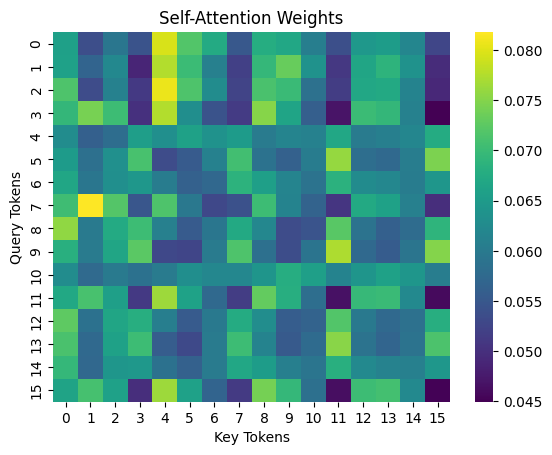

In [11]:
import torch.nn.functional as F
import seaborn as sns
mask = None
d_k = Q.size(-1) #last dim                      Scaling with math.sqrt(int) OR  torch.sqrt(tensor)
scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32)) 
if mask is not None:
    scores = scores.masked_fill(mask == 0, -1e9)
attn_weight = F.softmax(scores, dim=-1)
output = torch.matmul(attn_weight, V)
print("score.shape = " + str(scores.shape))
print("attn_weight.shape = " + str(attn_weight.shape))
print("output.shape = " + str(output.shape))

# Visualize attention weights for 0-th sequence : cmap="gray"
sns.heatmap(attn_weight[0].detach().numpy(), cmap="viridis")
plt.title("Self-Attention Weights")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()


def scaled_dot_product_attention(query, key, value, mask=None):
    d_k = query.size(-1) # last dim                       
    scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    attn_weight = F.softmax(scores, dim=-1)   # Attention Probabilities
    output = torch.matmul(attn_weight, value) # Expectation Val : Weighted Sum of Values
    return output, attn_weight



<details>
<summary>Self-Attention</summary>

```
• Self-Attention: query, key, and value matrices are derived 
from the same input, whereas cross-attention introduces a second input.

실제 트랜스포머 Q, K, V 생성 방식
embedding = nn.Embedding(vocab_size, d_model)  # 임베딩 벡터
x = embedding(input_tokens)                    # 임의의 실수값 (양수/음수 모두)
W_Q = nn.Linear(d_model, d_k)  # 학습되는 가중치 행렬
W_K = nn.Linear(d_model, d_k)
W_V = nn.Linear(d_model, d_v)
x : input image_tensor
query = W_Q(x)  # 행렬곱 결과 → 양수/음수, 범위 제한 없음
key   = W_K(x)
value = W_V(x)
```
</details>

In [ ]:
class SelfAttention(nn.Module):

    def __init__(self, embed_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        # Initialize Weights for Q, K, V : x'= W.x + b
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)

    def forward(self, x, mask=None):
        # Generate Q, K, V matrices
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        # Calculate attention using scaled dot-product function
        out, _ = scaled_dot_product_attention(Q, K, V, mask)
        return out